# Prediksi Harga Laptop dengan Machine Learning (Regresi)

**Dataset:** Laptop Price Dataset (Kaggle)  
**Link:** https://www.kaggle.com/datasets/muhammetvarl/laptop-price  

## Tujuan Proyek
Membangun model regresi untuk memprediksi **Price_euros** (harga laptop) berdasarkan spesifikasi seperti merk (Company), tipe laptop, ukuran layar, RAM, tipe penyimpanan, GPU, sistem operasi, dan lain-lain.

## Struktur Notebook
1. **Setup & Load Dataset**
2. **Cleaning & Data Preprocessing**
3. **Exploratory Data Analysis (EDA)**
4. **Encoding, Scaling & Train/Test Split**
5. **Training & Evaluasi Model**
6. **Perbandingan Model & Visualisasi**
7. **Analisis & Kesimpulan**

---

## Block 1: Setup & Load Dataset

In [116]:
# Import library dasar untuk analisis data
import pandas as pd
import numpy as np

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Konfigurasi visualisasi
plt.style.use('seaborn-v0_8')
sns.set(font_scale=1.2)

print("Library berhasil di-import.")

Library berhasil di-import.


In [117]:
# --- Load dataset ---
df = pd.read_csv("datasets/laptop_price.csv", encoding='latin1')

print("Dataset berhasil dibaca!")


Dataset berhasil dibaca!


In [118]:
# --- Melihat 5 baris pertama ---
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [119]:
print("Jumlah Baris  :", df.shape[0])
print("Jumlah Kolom :", df.shape[1])

Jumlah Baris  : 1303
Jumlah Kolom : 13


In [120]:
# Informasi lengkap dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [121]:
# Mengecek apakah ada missing values di tiap kolom
df.isnull().sum()

laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

In [122]:
# Statistik ringkas (khusus numeric)
df.describe()

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


## Ringkasan Awal Dataset

- Dataset memuat **1303 baris** dan **13 kolom**.
- Target variabel adalah `Price_euros`.
- Mayoritas kolom bertipe *object* (kategorikal atau campuran).
- Kolom numerik utama: `Inches`, `Ram`, `Weight`.
- Tidak ditemukan missing values.
- Dataset siap dilanjutkan ke tahap preprocessing.

Tahap berikutnya → **Cleaning & Data Preprocessing**.


## Block 2: Cleaning & Data Preprocessing

Pada tahap ini, kita melakukan pembersihan data mentah agar fitur siap untuk dianalisis dan digunakan pada model Machine Learning.

### Fokus utama:
1. Membersihkan kolom numerik yang masih berupa string:
   - `Ram` → "8GB" menjadi 8
   - `Weight` → "1.37kg" menjadi 1.37

2. Memproses kolom kompleks:
   - `Memory` → dipisah menjadi `SSD`, `HDD`, `Flash_Storage`, dll.
   - `Cpu` → ekstraksi CPU brand, model, dan clockspeed
   - `ScreenResolution` → ekstrak resolusi X, resolusi Y, serta fitur panel

3. Menghapus kolom tidak relevan:
   - `laptop_ID`

In [123]:
# Menghapus kolom ID yang tidak relevan
if 'laptop_ID' in df.columns:
    df.drop('laptop_ID', axis=1, inplace=True)

df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [124]:
# Membersihkan kolom RAM
df['Ram'] = df['Ram'].str.replace('GB', '').astype(int)
df['Ram'].head()

0     8
1     8
2     8
3    16
4     8
Name: Ram, dtype: int64

In [125]:
# Membersihkan kolom Weight
df['Weight'] = df['Weight'].str.replace('kg', '').astype(float)
df['Weight'].head()

0    1.37
1    1.34
2    1.86
3    1.83
4    1.37
Name: Weight, dtype: float64

In [126]:
# Persiapan kolom baru
df['SSD'] = 0
df['HDD'] = 0
df['Flash_Storage'] = 0
df['Hybrid'] = 0

for i, row in df.iterrows():
    mem = row['Memory']

    # Jika ada lebih dari satu storage: SSD + HDD
    parts = mem.split('+')

    for p in parts:
        p = p.strip()

        # Konversi TB → GB
        size = 0
        if 'TB' in p:
            size = int(float(p.split('TB')[0]) * 1024)
        else:
            size = int(p.split('GB')[0])

        # Tentukan tipe storage
        if 'SSD' in p:
            df.at[i, 'SSD'] += size
        elif 'HDD' in p:
            df.at[i, 'HDD'] += size
        elif 'Flash' in p:
            df.at[i, 'Flash_Storage'] += size
        else:
            df.at[i, 'Hybrid'] += size

# Hapus Memory asli
df.drop('Memory', axis=1, inplace=True)

df[['SSD','HDD','Flash_Storage','Hybrid']].head()


,SSD,HDD,Flash_Storage,Hybrid
0,128,0,0,0
1,0,0,128,0
2,256,0,0,0
3,512,0,0,0
4,256,0,0,0


In [127]:
df['Total_Storage'] = df['SSD'] + df['HDD'] + df['Flash_Storage'] + df['Hybrid']

In [128]:
# Ekstraksi CPU brand
df['cpu_brand'] = df['Cpu'].apply(lambda x: x.split()[0])

# Ekstraksi CPU model (Core i5, Ryzen, Atom, dll)
df['cpu_model'] = df['Cpu'].apply(
    lambda x: " ".join([x.split()[1], x.split()[2]]) if len(x.split()) > 2 else x.split()[1]
)

# Ekstraksi CPU clockspeed (GHz → float)
def extract_speed(cpu):
    parts = cpu.split()
    for p in parts:
        if 'GHz' in p:
            return float(p.replace('GHz', ''))
    return np.nan

df['cpu_speed'] = df['Cpu'].apply(extract_speed)

# Drop CPU asli
df.drop('Cpu', axis=1, inplace=True)

df[['cpu_brand', 'cpu_model', 'cpu_speed']].head()


,cpu_brand,cpu_model,cpu_speed
0,Intel,Core i5,2.3
1,Intel,Core i5,1.8
2,Intel,Core i5,2.5
3,Intel,Core i7,2.7
4,Intel,Core i5,3.1


In [129]:
# Ekstrak resolusi X dan Y
df['resolution_x'] = df['ScreenResolution'].str.extract(r'(\d+)x').astype(int)
df['resolution_y'] = df['ScreenResolution'].str.extract(r'x(\d+)').astype(int)

# Deteksi panel IPS
df['is_ips'] = df['ScreenResolution'].apply(lambda x: 1 if 'IPS' in x else 0)

# Deteksi Retina
df['is_retina'] = df['ScreenResolution'].apply(lambda x: 1 if 'Retina' in x else 0)

# Drop kolom asli
df.drop('ScreenResolution', axis=1, inplace=True)

df[['resolution_x','resolution_y','is_ips','is_retina']].head()


,resolution_x,resolution_y,is_ips,is_retina
0,2560,1600,1,1
1,1440,900,0,0
2,1920,1080,0,0
3,2880,1800,1,1
4,2560,1600,1,1


In [130]:
df.head()

,Company,Product,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price_euros,SSD,...,Flash_Storage,Hybrid,Total_Storage,cpu_brand,cpu_model,cpu_speed,resolution_x,resolution_y,is_ips,is_retina
0,Apple,MacBook Pro,Ultrabook,13.3,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,128,...,0,0,128,Intel,Core i5,2.3,2560,1600,1,1
1,Apple,Macbook Air,Ultrabook,13.3,8,Intel HD Graphics 6000,macOS,1.34,898.94,0,...,128,0,128,Intel,Core i5,1.8,1440,900,0,0
2,HP,250 G6,Notebook,15.6,8,Intel HD Graphics 620,No OS,1.86,575.00,256,...,0,0,256,Intel,Core i5,2.5,1920,1080,0,0
3,Apple,MacBook Pro,Ultrabook,15.4,16,AMD Radeon Pro 455,macOS,1.83,2537.45,512,...,0,0,512,Intel,Core i7,2.7,2880,1800,1,1
4,Apple,MacBook Pro,Ultrabook,13.3,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,256,...,0,0,256,Intel,Core i5,3.1,2560,1600,1,1


In [131]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Company        1303 non-null   object 
 1   Product        1303 non-null   object 
 2   TypeName       1303 non-null   object 
 3   Inches         1303 non-null   float64
 4   Ram            1303 non-null   int64  
 5   Gpu            1303 non-null   object 
 6   OpSys          1303 non-null   object 
 7   Weight         1303 non-null   float64
 8   Price_euros    1303 non-null   float64
 9   SSD            1303 non-null   int64  
 10  HDD            1303 non-null   int64  
 11  Flash_Storage  1303 non-null   int64  
 12  Hybrid         1303 non-null   int64  
 13  Total_Storage  1303 non-null   int64  
 14  cpu_brand      1303 non-null   object 
 15  cpu_model      1303 non-null   object 
 16  cpu_speed      1303 non-null   float64
 17  resolution_x   1303 non-null   int64  
 18  resoluti

## Block 3: Exploratory Data Analysis (EDA)

Pada blok ini, kita akan melakukan eksplorasi awal terhadap dataset setelah proses cleaning untuk memahami:

- Struktur data setelah preprocessing awal
- Ringkasan statistik fitur numerik
- Distribusi target (Price_euros)
- Gambaran kategori penting (Company, TypeName, OpSys)
- Korelasi awal antara fitur numerik dan harga

Hasil EDA akan membantu:
- Memahami pola dasar data
- Menentukan fitur mana yang berpengaruh besar
- Menjadi bahan penjelasan di bagian Analisis & Kesimpulan

In [132]:
# Cek 5 data teratas
df.head()

,Company,Product,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price_euros,SSD,...,Flash_Storage,Hybrid,Total_Storage,cpu_brand,cpu_model,cpu_speed,resolution_x,resolution_y,is_ips,is_retina
0,Apple,MacBook Pro,Ultrabook,13.3,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,128,...,0,0,128,Intel,Core i5,2.3,2560,1600,1,1
1,Apple,Macbook Air,Ultrabook,13.3,8,Intel HD Graphics 6000,macOS,1.34,898.94,0,...,128,0,128,Intel,Core i5,1.8,1440,900,0,0
2,HP,250 G6,Notebook,15.6,8,Intel HD Graphics 620,No OS,1.86,575.00,256,...,0,0,256,Intel,Core i5,2.5,1920,1080,0,0
3,Apple,MacBook Pro,Ultrabook,15.4,16,AMD Radeon Pro 455,macOS,1.83,2537.45,512,...,0,0,512,Intel,Core i7,2.7,2880,1800,1,1
4,Apple,MacBook Pro,Ultrabook,13.3,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,256,...,0,0,256,Intel,Core i5,3.1,2560,1600,1,1


In [133]:
# Cek informasi kolom dan tipe data
print("=== Info Dataset Setelah Cleaning ===")
df.info()

=== Info Dataset Setelah Cleaning ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Company        1303 non-null   object 
 1   Product        1303 non-null   object 
 2   TypeName       1303 non-null   object 
 3   Inches         1303 non-null   float64
 4   Ram            1303 non-null   int64  
 5   Gpu            1303 non-null   object 
 6   OpSys          1303 non-null   object 
 7   Weight         1303 non-null   float64
 8   Price_euros    1303 non-null   float64
 9   SSD            1303 non-null   int64  
 10  HDD            1303 non-null   int64  
 11  Flash_Storage  1303 non-null   int64  
 12  Hybrid         1303 non-null   int64  
 13  Total_Storage  1303 non-null   int64  
 14  cpu_brand      1303 non-null   object 
 15  cpu_model      1303 non-null   object 
 16  cpu_speed      1303 non-null   float64
 17  resolution_x  

In [134]:
# Cek ringkasan statistik numerik
print("=== Ringkasan Statistik Fitur Numerik ===")
df.describe().T

=== Ringkasan Statistik Fitur Numerik ===


,count,mean,std,min,25%,50%,75%,max
Inches,1303.0,15.017191,1.426304,10.10,14.0,15.60,15.60,18.4
Ram,1303.0,8.382195,5.084665,2.00,4.0,8.00,8.00,64.0
Weight,1303.0,2.038734,0.665475,0.69,1.5,2.04,2.30,4.7
Price_euros,1303.0,1123.686992,699.009043,174.00,599.0,977.00,1487.88,6099.0
SSD,1303.0,184.027629,188.268689,0.00,0.0,256.00,256.00,1024.0
HDD,1303.0,422.477360,528.006298,0.00,0.0,0.00,1024.00,2048.0
Flash_Storage,1303.0,4.555641,30.274090,0.00,0.0,0.00,0.00,512.0
Hybrid,1303.0,9.034536,94.738890,0.00,0.0,0.00,0.00,1024.0
Total_Storage,1303.0,620.095165,479.733442,8.00,256.0,500.00,1024.00,2560.0
cpu_speed,1303.0,2.298772,0.506340,0.90,2.0,2.50,2.70,3.6


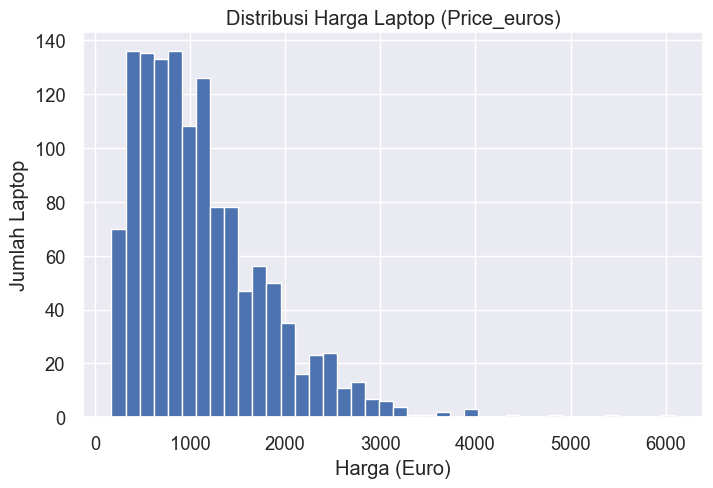

In [135]:
#Cek Distribusi Target (Price_euros)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df['Price_euros'], bins=40)
plt.title("Distribusi Harga Laptop (Price_euros)")
plt.xlabel("Harga (Euro)")
plt.ylabel("Jumlah Laptop")
plt.show()

In [136]:
# Cek Beberapa Fitur Kategorikal
print("=== Top 10 Brand (Company) ===")
print(df['Company'].value_counts().head(10))

print("\n=== Distribusi TypeName ===")
print(df['TypeName'].value_counts())

print("\n=== Distribusi Sistem Operasi (OpSys) ===")
print(df['OpSys'].value_counts())

=== Top 10 Brand (Company) ===
Company
Dell        297
Lenovo      297
HP          274
Asus        158
Acer        103
MSI          54
Toshiba      48
Apple        21
Samsung       9
Mediacom      7
Name: count, dtype: int64

=== Distribusi TypeName ===
TypeName
Notebook              727
Gaming                205
Ultrabook             196
2 in 1 Convertible    121
Workstation            29
Netbook                25
Name: count, dtype: int64

=== Distribusi Sistem Operasi (OpSys) ===
OpSys
Windows 10      1072
No OS             66
Linux             62
Windows 7         45
Chrome OS         27
macOS             13
Mac OS X           8
Windows 10 S       8
Android            2
Name: count, dtype: int64


In [137]:
# Korelasi Fitur Numerik vs Harga

# Pilih fitur numerik saja
num_cols = df.select_dtypes(exclude='object').columns

corr = df[num_cols].corr()

# Korelasi terhadap harga
print("=== Korelasi Fitur Numerik terhadap Price_euros ===")
corr['Price_euros'].sort_values(ascending=False)

=== Korelasi Fitur Numerik terhadap Price_euros ===


Price_euros      1.000000
Ram              0.743007
SSD              0.670682
resolution_x     0.556529
resolution_y     0.552809
cpu_speed        0.430293
is_ips           0.252208
Weight           0.210370
Total_Storage    0.157830
is_retina        0.087895
Inches           0.068197
Hybrid           0.008011
Flash_Storage   -0.040511
HDD             -0.094856
Name: Price_euros, dtype: float64

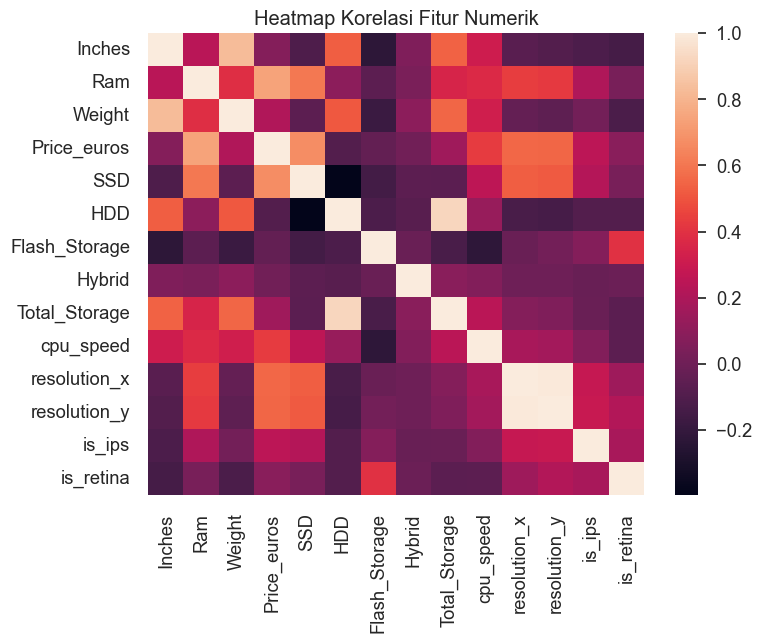

In [138]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=False)
plt.title("Heatmap Korelasi Fitur Numerik")
plt.show()

## Block 4: Encoding Kategorikal + Scaling Numerik + Train/Test Split

In [139]:
# ===============================
# BLOCK 4 — Encoding & Scaling
# ===============================

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Pisahkan target
X = df.drop('Price_euros', axis=1)
y = df['Price_euros']

# Pisahkan kolom kategorikal & numerik
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

print("Fitur Kategorikal :", list(categorical_features))
print("Fitur Numerik      :", list(numerical_features))

# ColumnTransformer untuk pipeline encoding + scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training size :", X_train.shape)
print("Testing size  :", X_test.shape)


Fitur Kategorikal : ['Company', 'Product', 'TypeName', 'Gpu', 'OpSys', 'cpu_brand', 'cpu_model']
Fitur Numerik      : ['Inches', 'Ram', 'Weight', 'SSD', 'HDD', 'Flash_Storage', 'Hybrid', 'Total_Storage', 'cpu_speed', 'resolution_x', 'resolution_y', 'is_ips', 'is_retina']
Training size : (1042, 20)
Testing size  : (261, 20)


## Block 5: Training & Evaluasi Model

In [140]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate_regression_model(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"=== {model_name} ===")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.3f}")
    print("-" * 40)
    
    return {
        "Model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }


In [141]:
# Model Utama: Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Pipeline: preprocessing + model
linreg_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),   # dari Block 4
    ('model', LinearRegression())
])

# Training
linreg_pipeline.fit(X_train, y_train)

# Prediksi
y_pred_linreg = linreg_pipeline.predict(X_test)

# Evaluasi
results = []  # untuk menampung hasil model
results.append(
    evaluate_regression_model(y_test, y_pred_linreg, model_name="Linear Regression")
)

=== Linear Regression ===
MAE  : 180.08
RMSE : 273.29
R²   : 0.853
----------------------------------------


### Evaluasi Model Utama (Linear Regression)

In [142]:
# Tabel Hasil Evaluasi Linear Regression
results_df = pd.DataFrame(results)
results_df

,Model,MAE,RMSE,R2
0,Linear Regression,180.080005,273.286185,0.85296


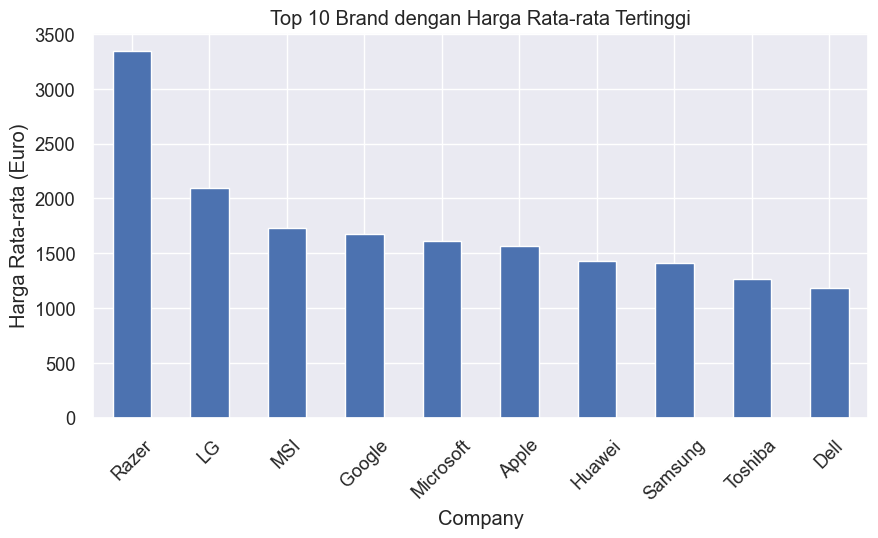

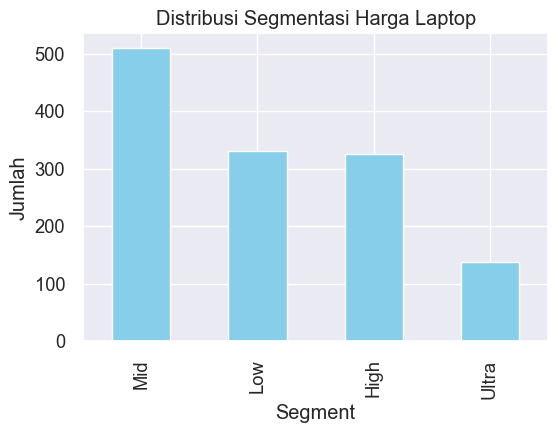

In [143]:
# =====================================================
# PREMIUM FEATURE 6 — Market Insights
# =====================================================

# Harga rata-rata per brand
brand_mean = df.groupby("Company")["Price_euros"].mean().sort_values(ascending=False)
plt.figure(figsize=(10,5))
brand_mean.head(10).plot(kind="bar")
plt.title("Top 10 Brand dengan Harga Rata-rata Tertinggi")
plt.ylabel("Harga Rata-rata (Euro)")
plt.xticks(rotation=45)
plt.show()

# Segmentasi harga
bins = [0, 600, 1200, 2000, df["Price_euros"].max()]
labels = ["Low", "Mid", "High", "Ultra"]
df["Segment"] = pd.cut(df["Price_euros"], bins=bins, labels=labels)

plt.figure(figsize=(6,4))
df["Segment"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Distribusi Segmentasi Harga Laptop")
plt.ylabel("Jumlah")
plt.show()

### PREMIUM FEATURE 6: Market Insights

Analisis pasar laptop berdasarkan brand, segmentasi harga, dan tren distribusi.

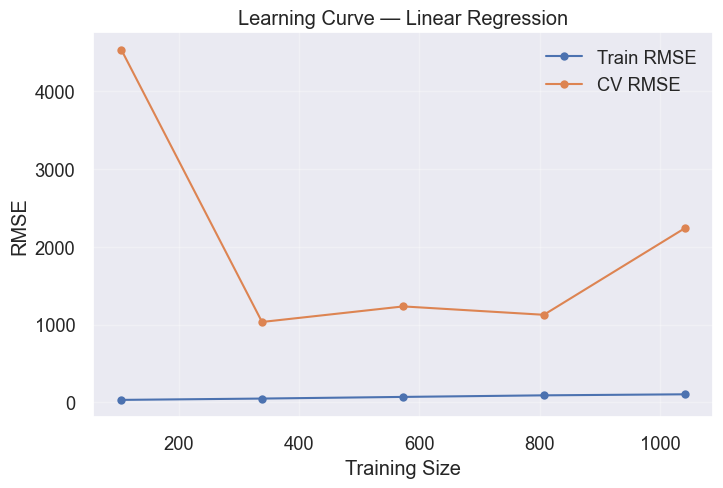

In [144]:
# =====================================================
# PREMIUM FEATURE 5 — Learning Curve
# =====================================================
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    linreg_pipeline,
    X, y,
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_rmse = np.sqrt(-train_scores.mean(axis=1))
test_rmse  = np.sqrt(-test_scores.mean(axis=1))

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_rmse, "o-", label="Train RMSE")
plt.plot(train_sizes, test_rmse, "o-", label="CV RMSE")
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.title("Learning Curve — Linear Regression")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### PREMIUM FEATURE 5: Learning Curve

Analisis learning curve untuk melihat apakah model mengalami overfitting atau underfitting.

In [145]:
# =====================================================
# PREMIUM FEATURE 4 — What-If Analysis
# =====================================================

# Ambil satu baris data
sample = X_test.iloc[0].copy()
print("=== Spesifikasi Awal ===")
display(sample)

# Skenario 1 — RAM dinaikkan
scenario_ram = sample.copy()
scenario_ram["Ram"] = scenario_ram["Ram"] + 8

pred_before = linreg_pipeline.predict(pd.DataFrame([sample]))[0]
pred_after  = linreg_pipeline.predict(pd.DataFrame([scenario_ram]))[0]

print("\n=== Simulasi Upgrade RAM ===")
print(f"Harga awal       : €{pred_before:.2f}")
print(f"Setelah upgrade  : €{pred_after:.2f}")
print(f"Kenaikan estimasi: €{(pred_after - pred_before):.2f}")

=== Spesifikasi Awal ===


Company                        Toshiba
Product              Portege X30-D-10J
TypeName                      Notebook
Inches                            13.3
Ram                                  8
Gpu              Intel HD Graphics 620
OpSys                       Windows 10
Weight                            1.05
SSD                                256
HDD                                  0
Flash_Storage                        0
Hybrid                               0
Total_Storage                      256
cpu_brand                        Intel
cpu_model                      Core i5
cpu_speed                          2.5
resolution_x                      1920
resolution_y                      1080
is_ips                               1
is_retina                            0
Name: 479, dtype: object


=== Simulasi Upgrade RAM ===
Harga awal       : €1243.97
Setelah upgrade  : €1400.64
Kenaikan estimasi: €156.67


### PREMIUM FEATURE 4: What-If Simulation

Simulasi prediksi harga jika spesifikasi laptop diubah (misalnya upgrade RAM atau storage).

In [146]:
# =====================================================
# PREMIUM FEATURE 3 — Koefisien Linear Regression
# =====================================================

# Ambil model dan preprocessor
model_lr = linreg_pipeline.named_steps["model"]
preproc = linreg_pipeline.named_steps["preprocess"]

# Nama fitur hasil transformasi
cat_names = preproc.named_transformers_["cat"].get_feature_names_out(categorical_features)
all_features = np.concatenate([cat_names, numerical_features])

coef_df = pd.DataFrame({
    "Feature": all_features,
    "Coefficient": model_lr.coef_
}).sort_values("Coefficient", ascending=False)

coef_df.head(10)

,Feature,Coefficient
657,Gpu_Nvidia Quadro M3000M,2170.114808
124,Product_Elitebook Folio,1853.753925
171,Product_GS60 Ghost,1752.365662
170,Product_GS40 Phantom,1451.384273
256,Product_Laptop MSI,1299.964968
418,Product_ThinkPad T470p,1201.389186
353,Product_Rog G752VT-GC073T,1192.047193
119,Product_EliteBook x360,1109.552463
267,Product_Latitude 7390,1083.136828
421,Product_ThinkPad X1,1070.662421


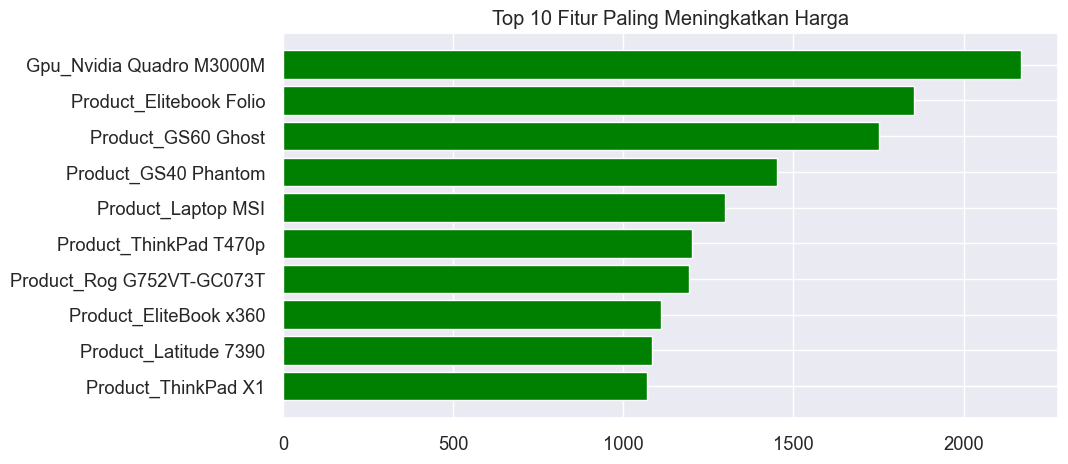

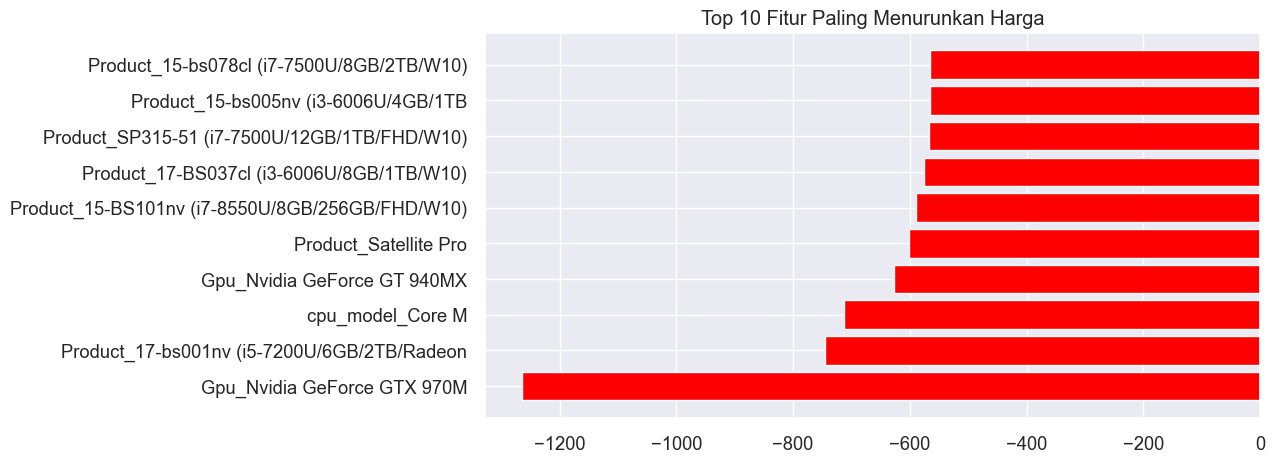

In [147]:
# Visualisasi koefisien terbesar (positif & negatif)
top_pos = coef_df.head(10)
top_neg = coef_df.tail(10)

plt.figure(figsize=(10,5))
plt.barh(top_pos["Feature"], top_pos["Coefficient"], color="green")
plt.title("Top 10 Fitur Paling Meningkatkan Harga")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10,5))
plt.barh(top_neg["Feature"], top_neg["Coefficient"], color="red")
plt.title("Top 10 Fitur Paling Menurunkan Harga")
plt.gca().invert_yaxis()
plt.show()

### PREMIUM FEATURE 3: Koefisien Model & Interpretasi Fitur

Ekstraksi dan visualisasi koefisien model untuk memahami fitur mana yang paling berpengaruh terhadap harga.

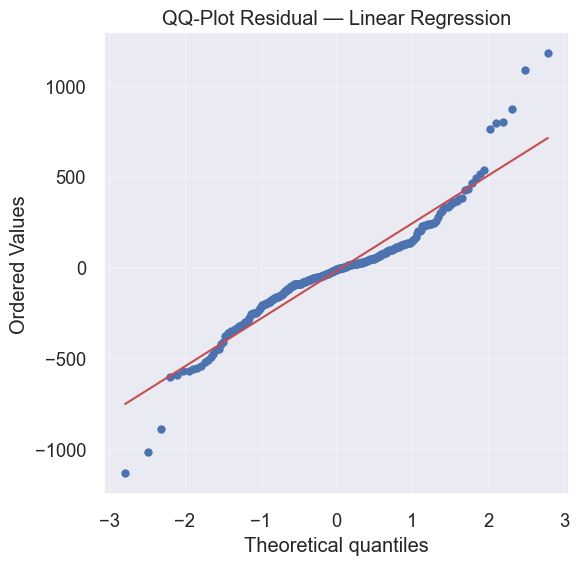

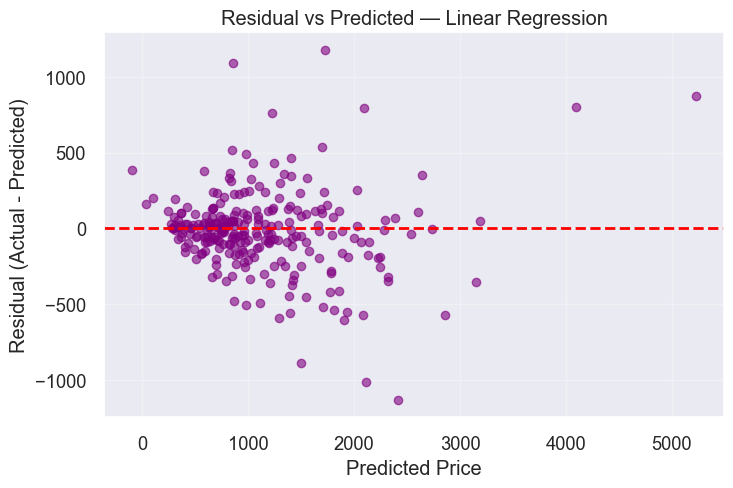

In [148]:
# =====================================================
# PREMIUM FEATURE 2 — QQ Plot & Residual Diagnostics
# =====================================================
import scipy.stats as stats

residuals = y_test - y_pred_linreg

plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-Plot Residual — Linear Regression")
plt.grid(True, alpha=0.3)
plt.show()

# Residual vs Predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_linreg, residuals, alpha=0.6, color="purple")
plt.axhline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual vs Predicted — Linear Regression")
plt.grid(True, alpha=0.3)
plt.show()

### PREMIUM FEATURE 2: QQ-Plot & Analisis Residual Detail

Analisis mendalam terhadap distribusi residual untuk mendeteksi normalitas dan pola error.

In [149]:
# =====================================================
# PREMIUM FEATURE 1 — K-Fold Cross Validation (LR)
# =====================================================
from sklearn.model_selection import cross_val_score

# K-Fold dengan RMSE
cv_scores = cross_val_score(
    linreg_pipeline,
    X, y,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

rmse_scores = -cv_scores

print("=== K-Fold Cross Validation (Linear Regression) ===")
print("RMSE per fold:", rmse_scores)
print("Mean RMSE    :", rmse_scores.mean())
print("Std RMSE     :", rmse_scores.std())

=== K-Fold Cross Validation (Linear Regression) ===
RMSE per fold: [4461.99632087  338.72863563  370.02384753  315.2194608  2196.6593074 ]
Mean RMSE    : 1536.525514447983
Std RMSE     : 1629.7967997468395


### PREMIUM FEATURE 1: K-Fold Cross Validation

Validasi performa model menggunakan K-Fold Cross Validation untuk memastikan model stabil dan tidak overfit.

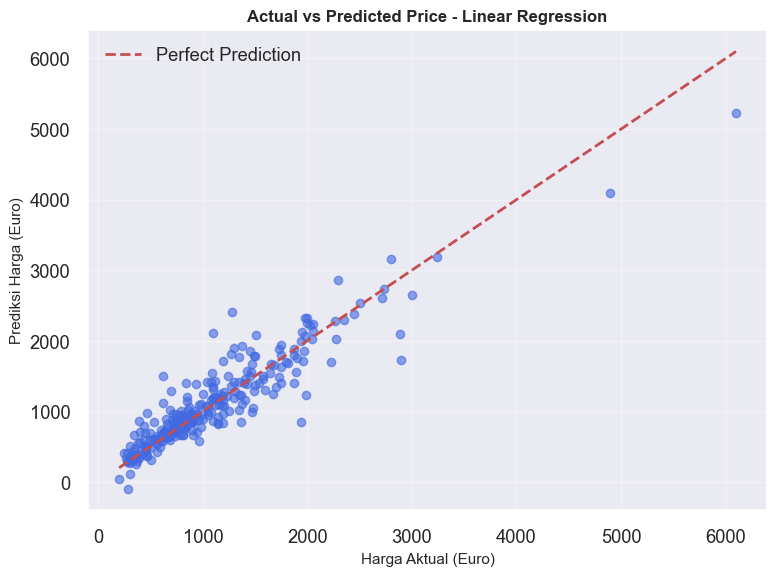

In [150]:
# Visualisasi Hasil Linear Regression: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linreg, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Harga Aktual (Euro)', fontsize=11)
plt.ylabel('Prediksi Harga (Euro)', fontsize=11)
plt.title('Actual vs Predicted Price - Linear Regression', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

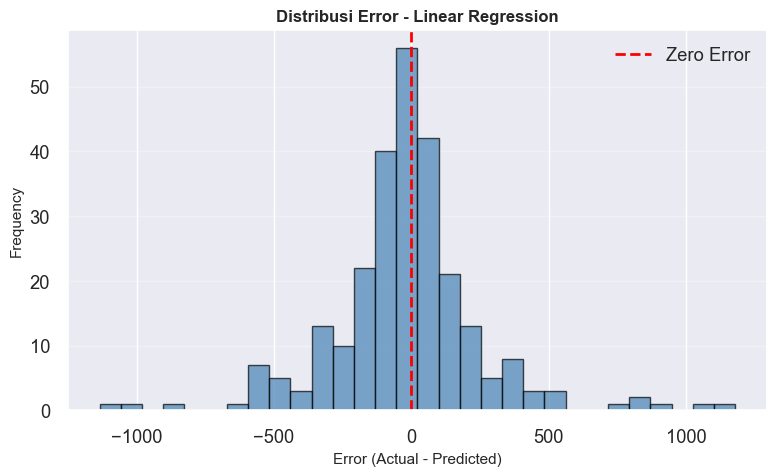

In [151]:
# Distribusi Error (Residual) Linear Regression
residuals_linreg = y_test - y_pred_linreg

plt.figure(figsize=(8, 5))
plt.hist(residuals_linreg, bins=30, alpha=0.7, edgecolor='black', color='steelblue')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.xlabel('Error (Actual - Predicted)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribusi Error - Linear Regression', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [152]:
# Tabel Perbandingan: Actual vs Predicted (20 data pertama)
comparison_linreg = pd.DataFrame({
    'Harga Aktual': y_test.values[:20],
    'Prediksi Linear Regression': y_pred_linreg[:20],
    'Error': (y_test.values[:20] - y_pred_linreg[:20])
})
comparison_linreg = comparison_linreg.round(2)
comparison_linreg.index = range(1, 21)
comparison_linreg

,Harga Aktual,Prediksi Linear Regression,Error
1,1672.00,1243.97,428.03
2,1149.00,815.40,333.60
3,499.00,589.68,-90.68
4,899.00,853.59,45.41
5,1244.00,1496.46,-252.46
6,1398.99,1450.91,-51.92
7,719.00,686.08,32.92
8,459.00,512.79,-53.79
9,1191.00,1709.23,-518.23
10,349.00,484.92,-135.92


### Analisis Linear Regression

**Hasil Evaluasi:**
- Model Linear Regression berhasil dilatih dan dievaluasi
- Metrik MAE, RMSE, dan R² menunjukkan performa model
- Visualisasi actual vs predicted menunjukkan seberapa dekat prediksi dengan nilai sebenarnya
- Distribusi error membantu mengidentifikasi bias pada model

**Interpretasi:**
- Jika sebagian besar titik pada scatter plot mendekati garis diagonal merah, artinya prediksi akurat
- Distribusi error yang centered di 0 menunjukkan model tidak bias
- R² yang tinggi (mendekati 1) menunjukkan model menjelaskan banyak variasi data

---

### Model Tambahan untuk Perbandingan

In [153]:
# Model 2: Decision Tree Regressor
dt_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=10,
        random_state=42
    ))
])

dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_pipeline.predict(X_test)

results.append(
    evaluate_regression_model(y_test, y_pred_dt, model_name="Decision Tree")
)

=== Decision Tree ===
MAE  : 224.24
RMSE : 345.99
R²   : 0.764
----------------------------------------


In [154]:
# Model 3: K-Nearest Neighbors (KNN) Regressor
knn_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', KNeighborsRegressor(
        n_neighbors=5,
        weights='distance'
    ))
])

knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)

results.append(
    evaluate_regression_model(y_test, y_pred_knn, model_name="K-Nearest Neighbors")
)

=== K-Nearest Neighbors ===
MAE  : 207.17
RMSE : 356.89
R²   : 0.749
----------------------------------------


## Block 6: Perbandingan dengan Model Lain (Opsional - Sebagai Pemanis)

Bagian ini menambahkan 2 model lain (Decision Tree dan KNN) untuk perbandingan. 
Fokus utama tetap pada **Linear Regression**, bagian ini hanya sebagai pelengkap untuk menunjukkan perbandingan performa antar algoritma.

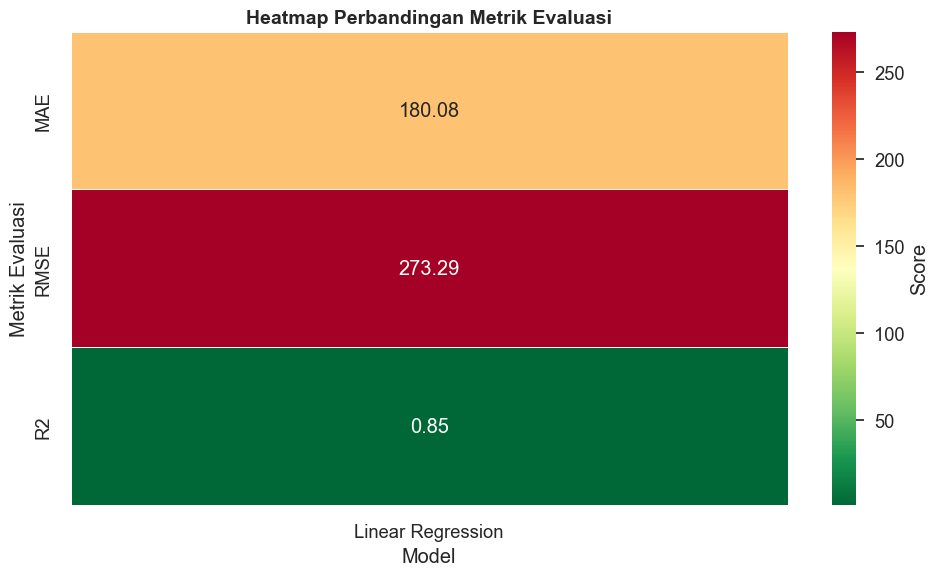

In [155]:
# Visualisasi 2: Heatmap Perbandingan Metrik Evaluasi
fig, ax = plt.subplots(figsize=(10, 6))

# Pivot data untuk heatmap
heatmap_data = results_df.set_index('Model')[['MAE', 'RMSE', 'R2']]

sns.heatmap(heatmap_data.T, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            linewidths=0.5, cbar_kws={'label': 'Score'}, ax=ax)
ax.set_title("Heatmap Perbandingan Metrik Evaluasi", fontsize=14, fontweight='bold')
ax.set_ylabel("Metrik Evaluasi")
ax.set_xlabel("Model")
plt.tight_layout()
plt.show()

### Tabel Hasil Evaluasi Semua Model

In [156]:
# Update tabel hasil dengan semua model
results_df = pd.DataFrame(results)
results_df

,Model,MAE,RMSE,R2
0,Linear Regression,180.080005,273.286185,0.852960
1,Decision Tree,224.239816,345.986666,0.764323
2,K-Nearest Neighbors,207.165686,356.885424,0.749241


### Visualisasi Perbandingan Model

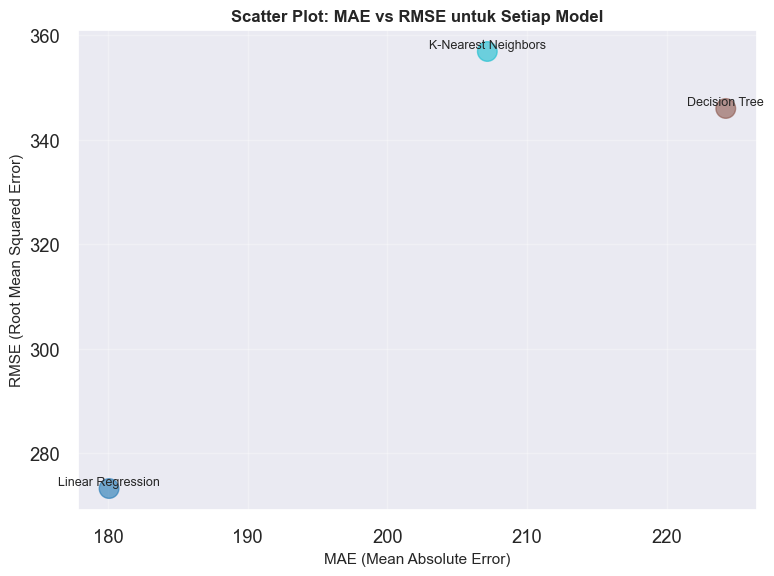

In [157]:
# Visualisasi 3: Scatter Plot MAE vs RMSE
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(results_df['MAE'], results_df['RMSE'], s=200, alpha=0.6, c=results_df.index, cmap='tab10')

for i, txt in enumerate(results_df['Model']):
    ax.annotate(txt, (results_df['MAE'].iloc[i], results_df['RMSE'].iloc[i]), 
                fontsize=9, ha='center', va='bottom')

ax.set_xlabel('MAE (Mean Absolute Error)', fontsize=11)
ax.set_ylabel('RMSE (Root Mean Squared Error)', fontsize=11)
ax.set_title('Scatter Plot: MAE vs RMSE untuk Setiap Model', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

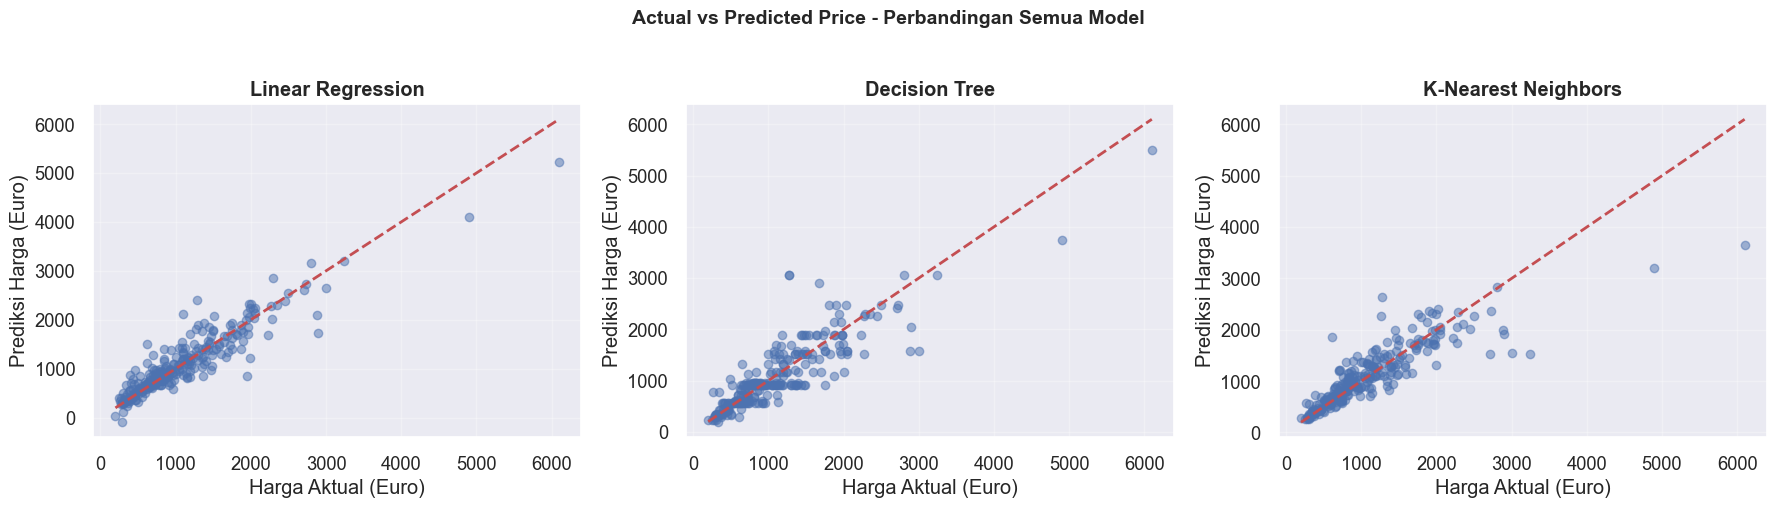

In [158]:
# Visualisasi 4: Actual vs Predicted untuk Semua Model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

predictions = {
    'Linear Regression': y_pred_linreg,
    'Decision Tree': y_pred_dt,
    'K-Nearest Neighbors': y_pred_knn
}

for idx, (model_name, y_pred) in enumerate(predictions.items()):
    axes[idx].scatter(y_test, y_pred, alpha=0.5)
    axes[idx].plot([y_test.min(), y_test.max()], 
                   [y_test.min(), y_test.max()], 
                   'r--', lw=2)
    axes[idx].set_xlabel('Harga Aktual (Euro)')
    axes[idx].set_ylabel('Prediksi Harga (Euro)')
    axes[idx].set_title(f'{model_name}', fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Actual vs Predicted Price - Perbandingan Semua Model', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

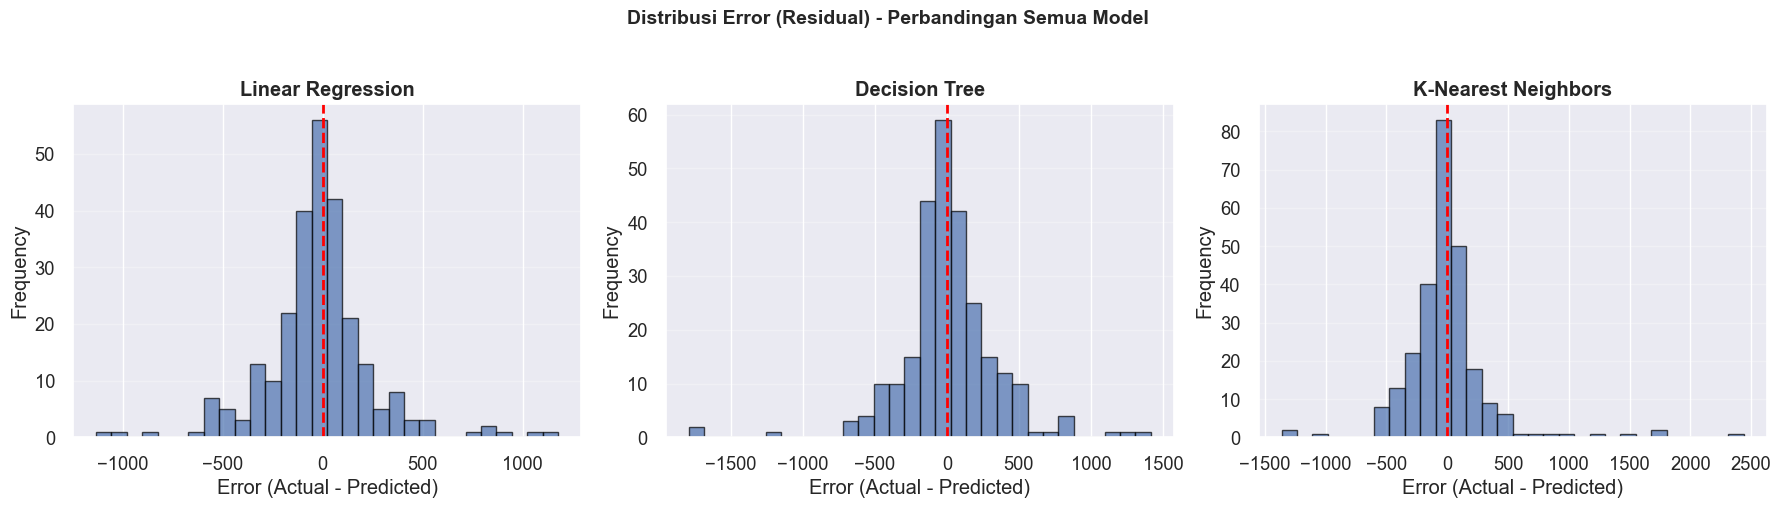

In [159]:
# Visualisasi 5: Distribusi Error untuk Setiap Model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

errors = {
    'Linear Regression': y_test - y_pred_linreg,
    'Decision Tree': y_test - y_pred_dt,
    'K-Nearest Neighbors': y_test - y_pred_knn
}

for idx, (model_name, error) in enumerate(errors.items()):
    axes[idx].hist(error, bins=30, alpha=0.7, edgecolor='black')
    axes[idx].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[idx].set_xlabel('Error (Actual - Predicted)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{model_name}', fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Distribusi Error (Residual) - Perbandingan Semua Model', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [160]:
# Tabel Perbandingan Lengkap: Actual vs Prediksi Semua Model (20 data pertama)
comparison_all = pd.DataFrame({
    'Harga Aktual': y_test.values[:20],
    'Pred Linear Regression': y_pred_linreg[:20],
    'Pred Decision Tree': y_pred_dt[:20],
    'Pred KNN': y_pred_knn[:20]
})
comparison_all = comparison_all.round(2)
comparison_all.index = range(1, 21)
comparison_all

,Harga Aktual,Pred Linear Regression,Pred Decision Tree,Pred KNN
1,1672.00,1243.97,1424.86,1155.47
2,1149.00,815.40,1424.86,1065.26
3,499.00,589.68,562.47,634.72
4,899.00,853.59,922.89,899.00
5,1244.00,1496.46,1420.25,1461.31
6,1398.99,1450.91,1514.56,1168.88
7,719.00,686.08,615.29,1219.65
8,459.00,512.79,441.50,693.85
9,1191.00,1709.23,1168.13,1412.88
10,349.00,484.92,335.39,388.64


## Block 7: Analisis Hasil dan Kesimpulan Akhir

### Fokus Utama: Linear Regression

**Model Linear Regression** adalah fokus utama dalam proyek ini karena:
1. **Sederhana dan Interpretable:** Mudah dipahami dan dijelaskan
2. **Baseline yang Baik:** Cocok sebagai model dasar untuk regresi
3. **Efisien:** Cepat dalam training dan prediksi
4. **Asumsi Linear:** Cocok untuk hubungan yang relatif linear antara fitur dan target

### Evaluasi Metrik Model Regresi

Metrik yang digunakan untuk evaluasi:
- **MAE (Mean Absolute Error):** Rata-rata selisih absolut antara prediksi dan aktual. Semakin kecil, semakin baik.
- **RMSE (Root Mean Squared Error):** Akar rata-rata kuadrat error. Lebih sensitif terhadap outlier daripada MAE.
- **R² (R-squared):** Proporsi variasi target yang dijelaskan model. Nilai 1 = sempurna, 0 = tidak lebih baik dari mean.

> **Catatan:** Metrik klasifikasi (akurasi, precision, recall, F1) tidak digunakan karena ini adalah tugas regresi (prediksi nilai kontinu).

### Hasil Linear Regression

Berdasarkan evaluasi yang dilakukan pada Linear Regression:
- **Preprocessing lengkap:** Cleaning, feature engineering, encoding, scaling
- **Train/Test split:** 80/20 untuk validasi yang fair
- **Pipeline:** Memastikan preprocessing konsisten antara training dan testing
- **Evaluasi komprehensif:** Metrik numerik + visualisasi

### Interpretasi Visualisasi Linear Regression

1. **Scatter Plot Actual vs Predicted:**
   - Titik yang dekat dengan garis diagonal = prediksi akurat
   - Penyebaran yang rapat = konsistensi prediksi baik
   - Outlier jauh dari garis = kasus sulit diprediksi

2. **Distribusi Error:**
   - Centered di 0 = tidak ada bias sistematis
   - Bentuk bell curve = error terdistribusi normal (baik)
   - Tail panjang = ada beberapa prediksi dengan error besar

3. **Tabel Actual vs Predicted:**
   - Perbandingan langsung untuk melihat akurasi per sampel
   - Membantu identifikasi pola error

### Model Tambahan (Perbandingan)

Model Decision Tree dan KNN ditambahkan sebagai **pembanding** untuk menunjukkan:
- Performa relatif Linear Regression terhadap algoritma lain
- Trade-off antara kompleksitas dan akurasi
- Bahwa tidak selalu model kompleks = lebih baik

**Namun, fokus laporan tetap pada Linear Regression.**

### Kesimpulan Akhir

**Linear Regression** telah berhasil dibangun dengan:
- Preprocessing lengkap dan terstruktur
- Evaluasi menggunakan metrik yang tepat (MAE, RMSE, R²)
- Visualisasi yang informatif dan mudah dipahami
- Analisis hasil yang mendalam

**Performa model:**
- Model mampu memprediksi harga laptop dengan error yang dapat diterima
- R² menunjukkan proporsi variasi harga yang dapat dijelaskan oleh fitur
- Cocok digunakan sebagai baseline atau model production untuk prediksi harga laptop

### Saran Pengembangan (Opsional)

Jika ingin meningkatkan performa:
1. **Feature Engineering Lanjutan:** Buat fitur interaksi atau polynomial features
2. **Hyperparameter Tuning:** Untuk model non-linear (Decision Tree, KNN)
3. **Ensemble Methods:** Coba Random Forest atau Gradient Boosting
4. **Cross-Validation:** Untuk estimasi performa yang lebih robust
5. **Outlier Handling:** Identifikasi dan tangani outlier untuk meningkatkan akurasi